# 02-02 : Multi-label text classification

After extracting intents, we use Keras, a comprehensive deep learning library, to develop a multi-class classification model.

## References

- [Large-scale multi-label text classification](https://keras.io/examples/nlp/multi_label_classification/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
from IPython.display import display, Markdown

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-03-18 09:34:21.198699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 09:34:21.198727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 09:34:21.199639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 09:34:21.204184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 09:34:21.696691: W tensorflow/compiler/tf2

## 1. Data Description

In [2]:
data_path = '../../data'

orig_data_path = f'{data_path}/hellopeter'
orig_file = f'{orig_data_path}/00-01_vodacom_selected_reviews.parquet.gz'

intent_path = f'{data_path}/multiclass_model'
intent_extract_file = f'{intent_path}/01-03_intents.parquet.gz'
intent_file = f'{intent_path}/02-01_flat_intents.parquet.gz'

### 1.1. Data Lineage

1. The original dataset is a collection publicly accessible customer reviews/complaints scraped from [Hellopeter](https://www.hellopeter.com/) site between 2021 and 2023. This dataset was [created](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/01_hellopeter/01-01_retrieve_data.ipynb) in another research project investigating: [Evaluating Customer Satisfaction and Preferences in the Telecommunications Industry: A Comparative Analysis of Survey Data and Online Reviews](https://github.com/JohnnyFoulds/dsm050-2023-apr/blob/master/notebooks/04_draft/04-04_cw02.ipynb)

2. Data selection was perform in the `00-01_data_selection` notebook based on the following criteria.
    - Reviews from the for the 5 month period from **2022-06-01** to **2023-06-30** were selected.

    - Only reviews from the **Vodacom** telecommunications company were selected.

    - Very short, or very long reviews were removed. Reviews between from **10** to **100** words were selected. The word count was calculated using a basic `.str.split().str.len()` which is sufficient for this purpose.

3. The unlabeled data was then labeled in the `01-02_batch_classification` notebook using Generative AI.
    - The **Mistral 7B v0.2** Large Language Model (LLM) were hosted on the local servier with [Ollama](https://ollama.com/library/mistral). Please refer to the `01-01_classification_test` notebook for further details.

    - The classification was done using multiple prompts similar to Chain-of-Thought (CoT) techniques for classification. _Implementation details can be found in the `src` directory._

    - Classification was done based on the categories defined in `src/config/category_definitions.jsonl`.

    - It took an average of **7 seconds** to classify a single review.

4. Using Generative AI for labeling introduced new categories that were cleaned up in the `01-03_cleanup` notebook.

    - First new categories that were prefixed with an original category were replaced.

    - Then, new categories that contained an original category in round brackets were replaced with the original.

    - For the remaining new categories, the reviews were manually inspected and the reviews were reclassified via manual mapping.

5. The data labels was then converted into a format suitable for modeling in the `02-01_data_preperation` notebook.

### 1.2. Data Structure

#### Source Data

The following shows a sample customer review from the original source data.

In [3]:
df_source = pd.read_parquet(orig_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_source[df_source.id == 3950575]
    )

,id,review_title,review_content
5215,3950575,Vodacom is useless!!!,"Good day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom."


### Data Labels

A sample of the labels extracted using the LLM is shown below. From this we can see that the LLM has extracted multiple labels for each review, and a reason is generated form each label for human verification.

In [4]:
df_intents_extracted = pd.read_parquet(intent_extract_file)
with pd.option_context('display.max_colwidth', None):
    display(
        df_intents_extracted[df_intents_extracted.id == 3950575]
    )

,category,reason,relevance,sentiment,id
29,Billing,The text mentions that an amount was debited from the account twice.,1.0,negative,3950575
30,Cancellation,The text expresses the intent to cancel all contracts with Vodacom due to the billing issue.,1.0,negative,3950575
31,Customer's Feeling,The text contains a negative sentiment towards Vodacom.,0.5,negative,3950575


### Prepared Data Labels

The prepared data labels are shown below. The data labels are prepared for multi-label classification.

This data will need to be combined with the `review_title` and `review_content` from the original source data to create the final dataset for modeling.

In [5]:
df_intents = pd.read_parquet(intent_file)
df_intents["category_list"] = df_intents["category_list"].apply(lambda x: list(x))
df_intents["relevance_list"] = df_intents["relevance_list"].apply(lambda x: list(x))
df_intents["sentiment_list"] = df_intents["sentiment_list"].apply(lambda x: list(x))

with pd.option_context('display.max_colwidth', None):
    display(
        df_intents[df_intents.id == 3950575]
    )

print(f'Data samples: {len(df_source)}')

,id,category_list,relevance_list,sentiment_list
2,3950575,"[Billing, Cancellation, Customer's Feeling]","[1.0, 1.0, 0.5]","[negative, negative, negative]"


Data samples: 5218


## 2. Data Preprocessing

### 2.1. Multi-label Binarization

In [6]:
# get the list of category target values
categories = tf.ragged.constant(df_intents.category_list.values)

# learn the vocabulary
lookup = keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(categories)

# show the vocabulary
vocab = lookup.get_vocabulary()
print("Vocabulary:\n")
print(lookup.get_vocabulary())
print(f'Vocabulary size: {len(vocab)}')

Vocabulary:

['[UNK]', "Customer's Feeling", 'Billing', 'Network Coverage', 'Cancellation', 'Call Center', 'Policy', 'Account Management', 'Response', 'Resolution', 'Devices', 'Staff Level', 'Price Plans', 'Brand', 'Abuse', 'Products', 'Service', 'Services', 'SIM', 'Other']
Vocabulary size: 20


2024-03-18 09:34:22.420499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 09:34:22.449108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 09:34:22.449286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

The following sample illustrates the binarization of the multi-labels. The multiple labels are encoded into a binary matrix where the positions corresponding with the labels have a value of 1.

In [7]:
# find a sample label to test the lookup
sample_label = df_intents[df_intents.id == 3950575].category_list.values[0]

print(f"Original label: {sample_label}")

# binarize the label
label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Billing', 'Cancellation', "Customer's Feeling"]
Label-binarized representation: [[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


The `invert_multi_hot` function is used to convert the binary matrix back into the original labels.

In [8]:
def invert_multi_hot(encoded_labels, lookup:keras.layers.StringLookup):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    # get the vocabulary
    vocab = lookup.get_vocabulary()

    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

## test the inverse function
invert_multi_hot(label_binarized[0], lookup)

array(["Customer's Feeling", 'Billing', 'Cancellation'], dtype='<U18')

### 2.2. Prepare Dataset

Prepare a dataset for training and testing.

In [9]:
# start from the original label dataset
df_preprocess = df_intents.copy()

# binarize the category_list
labels = tf.ragged.constant(df_preprocess["category_list"].values)
label_binarized = lookup(labels).numpy()
df_preprocess["category_encoded"] = label_binarized.tolist()

# add the review content
df_preprocess = df_preprocess \
    .set_index('id') \
    .join(df_source.set_index('id'), how='left') \
    .assign(review_text=lambda x: '**' + x.review_title + '**\n\n' + x.review_content) \
    .reset_index()

# select the relevant columns
df_preprocess = df_preprocess[['id', 'review_text', 'category_encoded']]

# show a sample of the preprocessed data
with pd.option_context('display.max_colwidth', None):
    display(df_preprocess.head(3))

,id,review_text,category_encoded
0,3950516,"**Vodacom fraudster**\n\nVodacom is a scam! Never ever take, a contract with those people. I had a, contract ending end October. End August I called them and cancelled the contract. I was suprised to find myself at credit bureau while I was looking for a house bond. They didn't cancel my contract. I call them, the system shows I indeed cancel the contract but they don't know why t wasn't cancelled. They are taking me from pillar to post and my life is at a, standstill. Fraudsters","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,3950535,"**bad service**\n\nstill awating any feedback from vodacom legal department ant the email address of DCA Hammond Pole, so that I can forward him all the mails to vodacom that has not been responded by Vodacom, and as stated two times allready, I dont have my number any more so cant phone the DCA, the messages has also been ignored by Vodacom","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,3950575,"**Vodacom is useless!!!**\n\nGood day\n\nAgain, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### 2.3. Train Test Split

In a multi-label classification problem, imbalance can occur at two levels:

1. **Label imbalance**: Some labels appear more frequently than others.
2. **Label combination imbalance**: Some combinations of labels appear more frequently than others.

Both these imbalances are present in the dataset. Imbalance can lead to a model that performs well on the majority classes but poorly on the minority classes. This is because the model might be biased towards predicting the majority classes due to their higher occurrence in the training data.

To address this, we will ideally use a stratified split to ensure that the distribution of labels in the training and validation sets is similar.

In [10]:
df_category_count = df_intents.category_list.value_counts().reset_index()
df_category_count.columns = ['category', 'samples']

print(f'Combination Category Count  : {len(df_category_count)}')
print(f'Combinations with one sample: {len(df_category_count[df_category_count.samples == 1])}')

Combination Category Count  : 376
Combinations with one sample: 128


Unfortunately we can see that about a third (0.34) of the unique category combinations have only one sample. This means that we will not be able to use a stratified split, as the validation set will not contain any of these unique combinations.

In [11]:
test_split = 0.2

# initial train and test split
train_full_df, test_df = train_test_split(
    df_intents,
    test_size=test_split
)

# splitting the train set further into validation and new train sets
val_df = train_full_df.sample(frac=0.2)
train_df = train_full_df.drop(val_df.index)

# select only the id column
train_full_ids = train_full_df.id.values
train_ids = train_df.id.values
val_ids = val_df.id.values
test_ids = test_df.id.values

# show the record counts per dataset
print(f"Number of rows in training set   : {len(train_ids):>5}")
print(f"Number of rows in validation set : {len(val_ids):>5}")
print(f"Number of rows in test set       : {len(test_ids):>5}")

Number of rows in training set   :  3214
Number of rows in validation set :   803
Number of rows in test set       :  1005


### 2.4. Make Datasets

Use the test-train split to create the final `tf.data.Dataset` objects for modeling.

In [12]:
def make_dataset(ids:np.ndarray, df:pd.DataFrame, batch_size:int=32, shuffle:bool=False):
    """Create a tf.data.Dataset from a pandas DataFrame."""
    # filter the dataframe to only the selected ids
    df = df[df.id.isin(ids)]

    # get the encoded labels and review text
    labels = np.array([np.array(lst) for lst in df.category_encoded.values])
    review_text = df.review_text.values

    # create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((review_text, labels))

    # shuffle the dataset if needed
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)

    # batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

Prepare the `tf.data.Dataset` objects.

In [13]:
batch_size = 150

train_dataset = make_dataset(train_ids, df_preprocess, batch_size, shuffle=True)
val_dataset = make_dataset(val_ids, df_preprocess, batch_size, shuffle=False)
test_dataset = make_dataset(test_ids, df_preprocess, batch_size, shuffle=False)

Dataset preview

In [14]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Review: {text}")
    print(f"Label(s): {invert_multi_hot(label[0], lookup=lookup)}")
    print(" ")

Review: b"**No solution**\n\nI have not paid my account... Then paid it to date, then been told that i lost my number. Call into customer services went throw the hole process of wanting to know why i lost the number. The reason i got was that i haven't paid which i can understand. In this months with me not paying the number was working perfectly fine until disconnection. Its been 20 or more days without a solution. All they say is they speaking to back office.. With no joy same feedback all the time its almost the next debit order date."
Label(s): ['Billing' 'Cancellation']
 
Review: b'**VODACOM - POOR SERVICE**\n\nI bought data on 22/09/2022. Never received it. I sent an e-mail and received a ref 002DSaHJQC9J3KRC. VODACOM said that they have sent my query to TOBi for investigation. Who the ???? and I nearly said that word is TOBi. I sent another email on 27 September just to be informed that TOBi is attending to this. Rest assured - I will never buy data from VODACOM as I only buy da

## 3. Modeling

In [15]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

### 3.1. Vectorization

Before we can train a model, we need to convert the text data into a format that can be fed into the model. There are multiple ways to do this, but a common approach is to convert text data into numerical data using a method such as TF-IDF, word embeddings, or a pre-trained language model.

For this purpose we will use the a `TextVectorization` layer that can operate as part of the main model so that the model is excluded from the core preprocessing logic. As noted in the [Keras documentation](https://keras.io/examples/nlp/multi_label_classification/) this also greatly reduces the chances of training / serving skew during inference.

Calculate the number of unique words in the dataset and the maximum length of a review.  
_We expect the maximum review length to be 100 words as we have filtered the reviews to be between 10 and 100 words._

In [16]:
# calculate the number of unique words in the dataset
vocabulary = set()
df_preprocess.review_text.str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f'Vocabulary size: {vocabulary_size}')

# get the maximum length of a review
max_review_length = int(df_preprocess.review_text.str.split().apply(len).max())
print(f'Maximum review length: {max_review_length}')

Vocabulary size: 20646
Maximum review length: 100


We will initial use a very simple `TextVectorization` layer with `'int'` output mode. In later iterations we can experiment with different vectorization layers,parameters, and output modes like `'tf-idf'` which is a simple, but quite effective technique in NLP text classification tasks.

In [17]:
def create_vectorizer(
        texts:List[str],
        max_tokens:int,
        output_mode:str='int',
        output_sequence_length:Optional[int]=None,
        ngrams:Optional[int]=None):
    """Create and adapt a vectorization layer for the given texts."""
    # create the layer
    text_vectorizer = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        ngrams=ngrams
    )

    # adapt the layer to the texts
    text_vectorizer.adapt(texts)

    return text_vectorizer

In [18]:
# create the vectorizer
text_vectorizer_layer = create_vectorizer(
    df_preprocess.review_text.values,
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=max_review_length
)

In [19]:
# test the vectorizer
sample_review = df_preprocess[df_preprocess.id == 3950575].review_text.values[0]
display(Markdown(sample_review))
print(f"Vectorized review: {text_vectorizer_layer([sample_review])}")

**Vodacom is useless!!!**

Good day

Again, vodacom did not do their jobs. The amount went off as I explicitly asked for it not to. Vodacom now owes me R300 as it has been debited from my account twice now. I will be taking this to social media now. And I want to please cancel all my contracts with vodacom.

Vectorized review: [[   6    9  116  247  126   91    6  108   16   46   49 1854    4  193
   169  148   41    2 3769  252   10   22   16    3    6   32 3025   14
  1632   41   22   36   28  256   26    8   39  463   32    2   42   34
   269   20    3  910  958   32    5    2   87    3   73   68   58    8
   177   17    6    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### 3.2. Baseline

For a multi-label text classification task in Natural Language Processing (NLP), a commonsense baseline could be designed using simple heuristics based on the frequency of specific keywords or phrases associated with each label. Multi-label classification differs from binary or multi-class classification in that each text instance can be associated with multiple labels simultaneously, rather than belonging to just one category.

To accomplish this we could start with  simple libraries like the [Natural Laugage Toolkit (NLTK)](https://www.nltk.org/) to tokenize the text and count the frequency of specific words or phrases associated with each label. We could then use these frequencies to predict the labels for new text instances. However for the sake of simplicity we will instead start with a very basic deep learning model.

In [20]:
def make_baseline_model(
        vectorization_layer: layers.TextVectorization,
        output_units:int,
        dense_units:(List[int]),
        dense_activation:Optional[str]='relu') -> keras.Model:
    """Create a simple feed-forward model that can be used as a baseline."""
    model = keras.Sequential()

    # add the vectorization layer
    model.add(vectorization_layer)

    # add the dense layers
    for units in dense_units:
        model.add(layers.Dense(units, activation=dense_activation))

    # add the output layer
    model.add(layers.Dense(output_units, activation='sigmoid'))

    return model

#### Create a text classification model

In [21]:
# get the baseline model
baseline_model = make_baseline_model(
    text_vectorizer_layer,
    output_units=len(lookup.get_vocabulary()),
    dense_units=[512],
    dense_activation='relu'
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 20)                10260     
                                                                 
Total params: 61972 (242.08 KB)
Trainable params: 61972 (242.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the model

In [22]:
epochs = 50

In [23]:
# compile the model
baseline_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'])

In [24]:
# train the model
history = baseline_model.fit(
    train_dataset, validation_data=val_dataset, epochs=epochs
)

Epoch 1/50


2024-03-18 09:34:24.556603: I external/local_xla/xla/service/service.cc:168] XLA service 0x7541eea88ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 09:34:24.556619: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-18 09:34:24.560036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 09:34:24.571102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710747264.627526  412613 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 1s 7ms/step - loss: 70.2432 - binary_accuracy: 0.8252 - val_loss: 46.3014 - val_binary_accuracy: 0.8296
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 32.8838 - binary_accuracy: 0.8539 - val_loss: 34.7831 - val_binary_accuracy: 0.8424
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 22.1458 - binary_accuracy: 0.8601 - val_loss: 30.7873 - val_binary_accuracy: 0.8348
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 16.5973 - binary_accuracy: 0.8649 - val_loss: 29.1587 - val_binary_accuracy: 0.8323
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 13.1447 - binary_accuracy: 0.8742 - val_loss: 28.1171 - val_binary_accuracy: 0.8332
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 10.6174 - binary_accuracy: 0.8786 - val_loss: 27.2422 - val_binary_accuracy: 0.8385
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 8.7

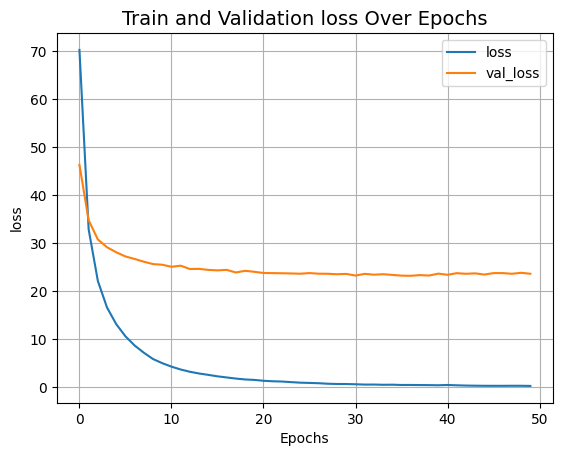

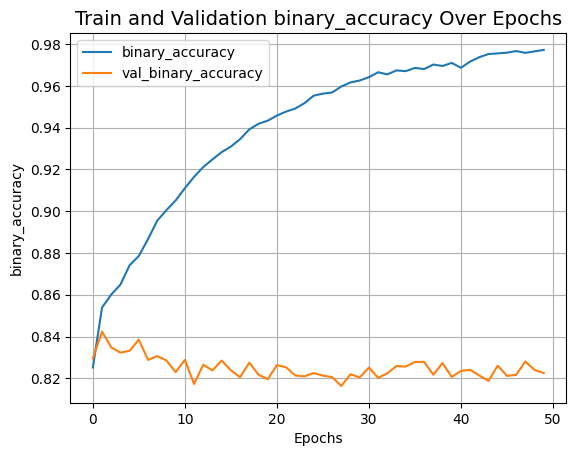

In [25]:
plot_result("loss")
plot_result("binary_accuracy")

#### Evaluate the model

In [26]:
_, binary_acc = baseline_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

7/7 [==============================] - 0s 2ms/step - loss: 22.4943 - binary_accuracy: 0.8222
Categorical accuracy on the test set: 82.22%.
